# Project: Emotion Detection

In this project, you will adapt the original Cat vs. Dog project to work with the **RAVDESS_Emotional_speech_audio** dataset for emotion detection. Below is a summary of the key modifications you will need to make, along with instructions on what parts you need to complete:

---

#### 1. Dataset and File Structure

- **Original Project:**  
  - Used a dataset with files labeled as either "cat" or "dog".

- **New Emotion Dataset (RAVDESS):**  
  - The dataset is organized into 24 subdirectories (e.g., `Actor_01`, `Actor_02`, …, `Actor_24`), each containing 60 `.wav` files.
  - **Filename Format:**  
    The file names follow this format:  
    ```
    Modality-VocalChannel-Emotion-EmotionalIntensity-Statement-Repetition-Actor.wav
    ```
    For example, `03-01-06-01-02-01-12.wav` means:  
    - **Emotion Code:** The 3rd part (`06`) indicates the emotion (in this case, "Fearful").

- **Your Task:**  
  - Adapt the code to recursively load `.wav` files from the RAVDESS dataset.
  - Parse the filename (split by `'-'`) to extract the emotion code.
  
---

#### 2. Label Mapping

- **Original Project:**  
  - Labels were assigned based on the filename prefix ("cat" or "dog").

- **New Emotion Labels:**  
  - Create a mapping from the emotion code (from the filename) to a numerical label. For example:
    - `"01"` → Neutral  
    - `"02"` → Calm  
    - `"03"` → Happy  
    - `"04"` → Sad  
    - `"05"` → Angry  
    - `"06"` → Fearful  
    - `"07"` → Disgust  
    - `"08"` → Surprised

- **Your Task:**  
  - Use a dictionary (e.g., `emotion_map`) to map these codes to labels.
  - Convert the labels to integers (e.g., 0 to 7).

---

#### 3. Multi-class Classification

- **Original Project:**  
  - Solved a binary classification problem (cat vs. dog).

- **New Emotion Detection:**  
  - You now have 8 emotion classes.
  - **Random Forest Classifier:**  
    - Continue using statistical summaries of MFCC features, but ensure that the classifier is trained with multi-class labels.
  - **Convolutional Neural Network (CNN):**  
    - Change the output layer to have **8 neurons** with a **softmax activation** function.
    - Update the loss function to `sparse_categorical_crossentropy` for multi-class classification.

- **Your Task:**  
  - Modify the CNN architecture accordingly.
  - Verify that your evaluation metrics and confusion matrix display the 8 classes.

---

#### 4. Feature Extraction and Visualization

- **Similarities:**  
  - The process for extracting MFCC features (including deltas) remains largely the same.
  - Visualization of the audio waveform and MFCC heatmap (using `imshow` or similar) is still applicable.

- **Your Task:**  
  - Adapt the feature extraction code to work with the RAVDESS dataset.
  - Ensure that the visualization parts still help you verify the quality of the extracted features.

---

#### 5. Additional Notebook for Inference on New Audio

- **New Requirement:**  
  - Create a **separate notebook** where you:
    - Record your own voice using the microphone.
    - Apply the trained model (which you saved from this project) to predict the emotion in your recording.
  
- **Your Task:**  
  - Build a new notebook that includes:
    - Code to record audio from the microphone.
    - Feature extraction code (to compute MFCCs from your recording).
    - Code to load the pre-trained model (Random Forest and/or CNN) and output the predicted emotion.
  

## Imports and Helper Functions

In [1]:
import os
import glob
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import sounddevice as sd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from keras import layers, models
from keras.models import load_model

2025-04-10 23:17:18.456994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-10 23:17:18.472832: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-10 23:17:18.477265: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-10 23:17:18.488611: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import sys
project_path = os.path.abspath('.')
if project_path not in sys.path:
    sys.path.append(project_path) # for src.util  

In [3]:
import warnings
warnings.filterwarnings("ignore")

#### Emotion mapping: convert emotion code (string) to integer label (0-based)

In [4]:
emotion_map = {
    "01": 0,  # Neutral
    "02": 1,  # Calm
    "03": 2,  # Happy
    "04": 3,  # Sad
    "05": 4,  # Angry
    "06": 5,  # Fearful
    "07": 6,  # Disgust
    "08": 7   # Surprised
}

emotion_labels = ["Neutral", "Calm", "Happy", "Sad", "Angry", "Fearful", "Disgust", "Surprised"]

#### Function to extract statistical MFCC features (for Random Forest)

In [5]:
def extract_statistical_features(file_path, n_mfcc=13):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        delta_mean = np.mean(mfcc_delta, axis=1)
        delta_std = np.std(mfcc_delta, axis=1)
        delta2_mean = np.mean(mfcc_delta2, axis=1)
        delta2_std = np.std(mfcc_delta2, axis=1)
        features = np.concatenate([mfcc_mean, mfcc_std, delta_mean, delta_std, delta2_mean, delta2_std])
        return features, y, sr, mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None, None, None

#### Function to extract fixed-size MFCC image for CNN

In [6]:
def get_mfcc_image(file_path, n_mfcc=13, max_len=216):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        # Pad or truncate the MFCC to have a fixed number of frames (max_len)
        mfcc_fixed = librosa.util.fix_length(mfcc, size=max_len, axis=1)
        return mfcc_fixed
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

## Load Dataset and Extract Features

#### Define dataset path and recursively get all .wav files from the dataset

In [7]:
audio_files = glob.glob(os.path.join(project_path, 'dataset', '**', '*.wav'), recursive=True)

assert len(audio_files) > 0, "Audio files not found"

print("Number of audio files found:", len(audio_files))


Number of audio files found: 2880


#### Initialize lists for features and labels

In [8]:
features_list = []
labels_list = []
waveforms = []   # For visualization
sample_rates = []  # For visualization
mfccs = []       # For visualization
file_names = []  # To store file paths

# For CNN images
cnn_images = []


#### Process each audio file

In [9]:

for file_path in audio_files:
    # Extract statistical features for Random Forest
    features, y, sr, mfcc = extract_statistical_features(file_path, n_mfcc=13)
    if features is not None:
        features_list.append(features)
        waveforms.append(y)
        sample_rates.append(sr)
        mfccs.append(mfcc)
        file_names.append(file_path)
        
        # Parse the filename to extract the emotion code (3rd part of the filename)
        base_name = os.path.basename(file_path)
        parts = base_name.split('-')
        if len(parts) >= 3:
            emotion_code = parts[2]
            label = emotion_map.get(emotion_code, -1)  # default to -1 if not found
            labels_list.append(label)
        else:
            labels_list.append(-1)
        
        # Extract MFCC image for CNN classifier
        mfcc_img = get_mfcc_image(file_path, n_mfcc=13, max_len=216)
        if mfcc_img is not None:
            cnn_images.append(mfcc_img)

#### Convert lists to numpy arrays

In [10]:
features_array = np.array(features_list)
labels_array = np.array(labels_list)
cnn_images = np.array(cnn_images)

print("Features array shape (Random Forest):", features_array.shape)
print("Labels array shape:", labels_array.shape)
print("CNN images shape:", cnn_images.shape)  # Expected shape: (num_samples, 13, 216)

Features array shape (Random Forest): (2880, 78)
Labels array shape: (2880,)
CNN images shape: (2880, 13, 216)


## Visualize an Example Audio File and its MFCC Heatmap

#### Plot the audio waveform

In [11]:
# CODE
example_index = 0
y_example = waveforms[example_index]
sr_example = sample_rates[example_index]
mfcc_example = mfccs[example_index]

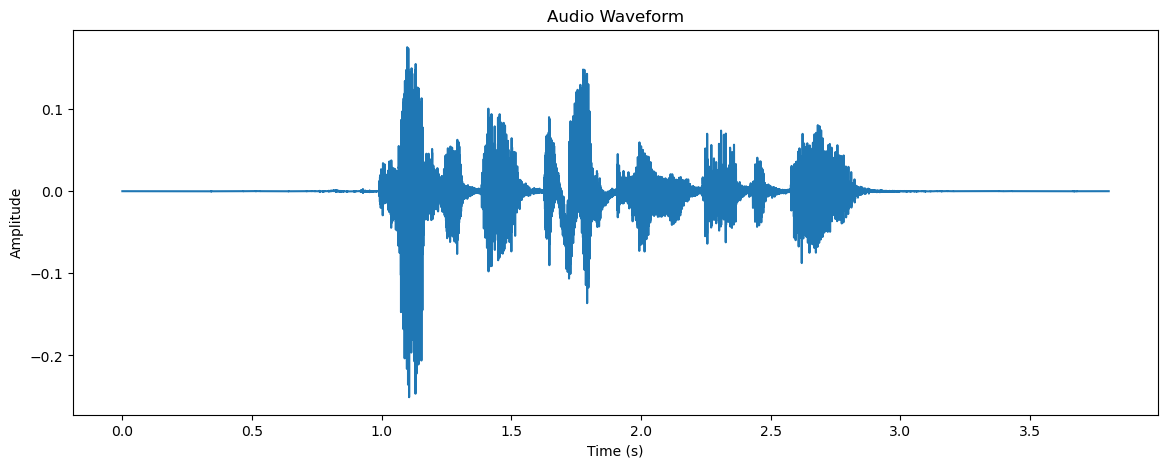

In [12]:
# CODE
# Create a time vector in seconds
t = np.linspace(0, len(y_example) / sr_example, num=len(y_example))

plt.figure(figsize=(14, 5))
plt.plot(t, y_example)
plt.title("Audio Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

#### Plot the MFCC heatmap using imshow (as an alternative to specshow)

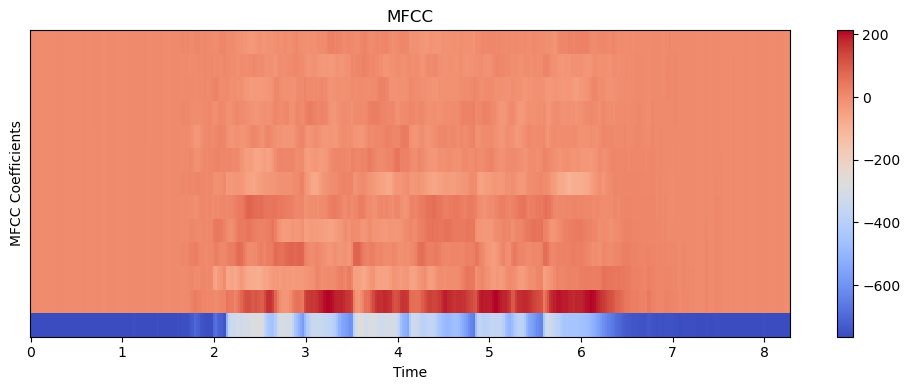

In [13]:
# CODE
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc_example, x_axis='time')
plt.colorbar()
plt.title("MFCC")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.tight_layout()
plt.show()

## Random Forest classifier

#### Train-Test Split

In [14]:
# CODE
X_train, X_test, y_train, y_test = train_test_split(features_array, labels_array, test_size=0.2, random_state=42, stratify=labels_array)

#### Train a Random Forest classifier

In [15]:
# CODE
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### Evaluate on the test set

In [16]:
# CODE
y_pred_rf = rf_clf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       0.90      0.97      0.94        76
           2       0.90      0.90      0.90        77
           3       0.80      0.84      0.82        77
           4       0.97      0.79      0.87        77
           5       0.84      0.82      0.83        77
           6       0.90      0.90      0.90        77
           7       0.88      0.95      0.91        77

    accuracy                           0.89       576
   macro avg       0.90      0.90      0.90       576
weighted avg       0.89      0.89      0.89       576

Random Forest Accuracy: 0.8888888888888888


#### Plot the confusion matrix

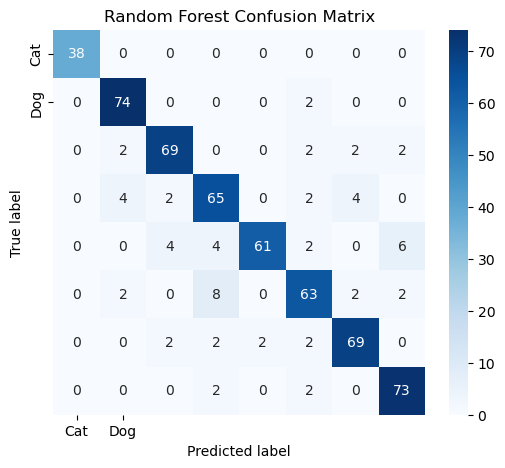

In [17]:
# CODE
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Random Forest Confusion Matrix")
plt.show()

In [18]:
# Save the rf model
joblib.dump(rf_clf, os.path.join(project_path, 'models/random_forest_model.pkl'))

['/home/gukardm/Course/med-analytics/hw3_audio_emotions/models/random_forest_model.pkl']

## Prepare Data and Train the CNN Classifier

#### Expand dimensions of CNN images to add a channel dimension (required by CNNs)

In [19]:
# cnn_images_exp = cnn_images[..., np.newaxis]  # New shape: (num_samples, 13, 216, 1)
cnn_images_exp = np.expand_dims(cnn_images, axis=-1)
assert len(cnn_images.shape) == 3, "dimension error?"

print(cnn_images_exp.shape)

(2880, 13, 216, 1)


#### Split data for the CNN classifier

In [20]:
# CODE
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(cnn_images_exp, labels_array, test_size=0.2, random_state=42, stratify=labels_array)

In [21]:
import tensorflow as tf

# y_train_cnn = tf.one_hot(y_train_cnn, len(emotion_labels))
# y_test_cnn = tf.one_hot(y_test_cnn, len(emotion_labels))

#### Build the CNN model for multi-class classification

In [22]:
input_shape = X_train_cnn.shape[1:]
print(input_shape)

num_classes = len(emotion_labels)
print(num_classes)

(13, 216, 1)
8


In [23]:
# CODE
cnn_model = models.Sequential([
    layers.Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),

    layers.Conv2D(256, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),

    layers.Conv2D(256, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),

    layers.Conv2D(256, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    
    layers.Flatten(),

    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),


    layers.Dense(num_classes, activation='softmax')
])

I0000 00:00:1744341482.335394  114057 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744341482.379662  114057 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744341482.379960  114057 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744341482.381348  114057 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [24]:
# CODE
from keras.callbacks import EarlyStopping, ModelCheckpoint
callback = EarlyStopping(monitor='val_loss', patience=10)

# Save the epoch with the lowest loss
checkpoint = ModelCheckpoint(os.path.join(project_path, 'models/sparse_cnn_model.keras'), monitor='val_loss', save_best_only=True, mode='min', verbose=1)

#### Compile the model

In [25]:
# CODE
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']),
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 11, 214, 128)   │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 11, 214, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 9, 212, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 9, 212, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 210, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 210, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 208, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 2, 104, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 104, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 53248)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    27,263,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,877,064 (110.16 MB)

 Trainable params: 28,875,272 (110.15 MB)

 Non-trainable params: 1,792 (7.00 KB)

#### Train the CNN model

In [26]:
# CODE
history = cnn_model.fit(X_train_cnn, y_train_cnn, epochs=100, batch_size=16, validation_split=0.2, callbacks=[callback, checkpoint])

Epoch 1/100


I0000 00:00:1744341485.373363  114409 service.cc:146] XLA service 0x7f134c004460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744341485.373387  114409 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-04-10 23:18:05.426936: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-10 23:18:05.664296: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
2025-04-10 23:18:06.074035: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1345', 8 bytes spill stores, 8 bytes spill loads

2025-04-10 23:18:09.730707: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.17GiB with fre

  7/116 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.0886 - loss: 20.3983

I0000 00:00:1744341493.401133  114409 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


113/116 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2140 - loss: 9.6025

2025-04-10 23:18:17.194150: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1345', 8 bytes spill stores, 8 bytes spill loads

2025-04-10 23:18:18.603856: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2154 - loss: 9.4880

2025-04-10 23:18:23.773351: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_142', 8 bytes spill stores, 8 bytes spill loads




Epoch 1: val_loss improved from inf to 3.78724, saving model to /home/gukardm/Course/med-analytics/hw3_audio_emotions/models/sparse_cnn_model.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 24s 117ms/step - accuracy: 0.2158 - loss: 9.4510 - val_accuracy: 0.2148 - val_loss: 3.7872
Epoch 2/100
115/116 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4233 - loss: 1.7175
Epoch 2: val_loss improved from 3.78724 to 2.38285, saving model to /home/gukardm/Course/med-analytics/hw3_audio_emotions/models/sparse_cnn_model.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.4237 - loss: 1.7163 - val_accuracy: 0.3818 - val_loss: 2.3828
Epoch 3/100
114/116 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5430 - loss: 1.4280
Epoch 3: val_loss improved from 2.38285 to 1.39814, saving model to /home/gukardm/Course/med-analytics/hw3_audio_emotions/models/sparse_cnn_model.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5433 - loss: 1.4263 - val_accuracy: 0.4859 - val_loss: 1.3981
Epoch 4/100
114

#### Evaluate the CNN model on the test set

In [27]:
# CODE
cnn_eval = cnn_model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print("CNN Test Loss: {:.4f}, Test Accuracy: {:.4f}".format(cnn_eval[0], cnn_eval[1]))

2025-04-10 23:19:25.704822: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_149', 4 bytes spill stores, 4 bytes spill loads



CNN Test Loss: 1.4763, Test Accuracy: 0.7569


In [28]:
from src.utils import plot_results

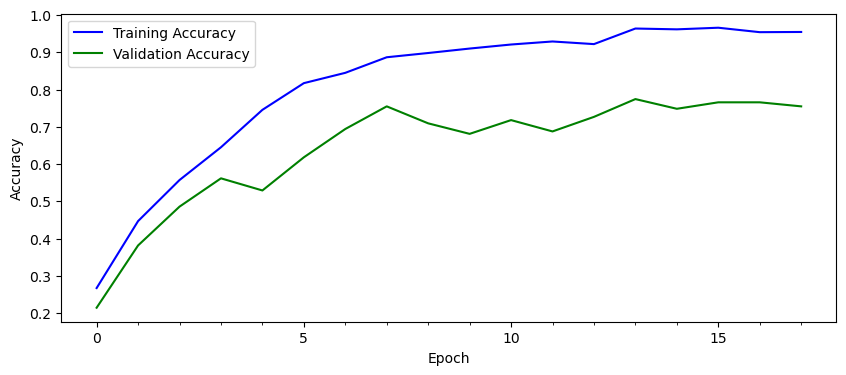

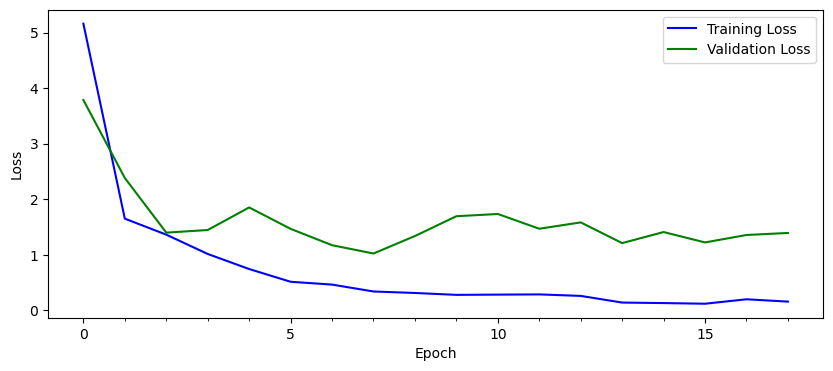

In [29]:
# Retrieve training results.
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]
    
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["b", "g"])

plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            metric_name=["Training Loss", "Validation Loss"],
            color=["b", "g"]);

## Save the Trained Models

In [30]:
# CODE
# cnn_model.save('models/cnn_model.keras') Dont need to do this as we already saved the best model

## Load the saved models

In [31]:
# CODE
loaded_cnn_model = load_model(os.path.join(project_path, 'models/sparse_cnn_model.keras'))

## Inference on a New Audio File or via Microphone Recording

In [32]:
# Set source = 'file' to use an external audio file (e.g., 'new_audio.wav')
# Set source = 'mic' to record audio from the microphone

source = 'mic'  # Change to 'file' if you want to use an external file

if source == 'file':
    # Inference using an external audio file
    new_audio_path = 'new_audio.wav'  # Provide the path to your audio file
    
    # Extract features for the Random Forest model
    features_new, y_new, sr_new, mfcc_new = extract_statistical_features(new_audio_path, n_mfcc=13)
    if features_new is not None:
        features_new = features_new.reshape(1, -1)
    
    # Extract MFCC image for the CNN model
    mfcc_img_new = get_mfcc_image(new_audio_path, n_mfcc=13, max_len=216)
    if mfcc_img_new is not None:
        mfcc_img_new = mfcc_img_new[np.newaxis, ..., np.newaxis]

elif source == 'mic':
    duration = 3  # seconds to record
    fs = 48000   # Sampling rate
    print(f"Recording audio for {duration} seconds...")
    recording = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='float32')
    sd.wait() 
    y_new = recording.flatten()  
    sr_new = fs
    print("Recording complete.")

    mfcc_record = librosa.feature.mfcc(y=y_new, sr=sr_new, n_mfcc=13)
    mfcc_delta = librosa.feature.delta(mfcc_record)
    mfcc_delta2 = librosa.feature.delta(mfcc_record, order=2)
    mfcc_mean = np.mean(mfcc_record, axis=1)
    mfcc_std = np.std(mfcc_record, axis=1)
    delta_mean = np.mean(mfcc_delta, axis=1)
    delta_std = np.std(mfcc_delta, axis=1)
    delta2_mean = np.mean(mfcc_delta2, axis=1)
    delta2_std = np.std(mfcc_delta2, axis=1)
    
    # Concatenate statistical features for Random Forest prediction
    features_new = np.concatenate([mfcc_mean, mfcc_std, delta_mean, delta_std, delta2_mean, delta2_std]).reshape(1, -1)

    
    # For the CNN model, create a fixed-size MFCC image
    max_len = 216
    mfcc_img_new = librosa.util.fix_length(mfcc_record, size=max_len, axis=1)
    mfcc_img_new = mfcc_img_new[np.newaxis, ..., np.newaxis]
else:
    raise ValueError("Invalid source selected. Please set source to 'file' or 'mic'.")

Recording audio for 3 seconds...
Recording complete.


#### Make predictions using the trained models

In [33]:
emotion_labels = ["Neutral", "Calm", "Happy", "Sad", "Angry", "Fearful", "Disgust", "Surprised"]

rf_pred_new = rf_clf.predict(features_new)[0]
cnn_pred_probs_new = cnn_model.predict(mfcc_img_new)[0]
cnn_pred_new = np.argmax(cnn_pred_probs_new)

print("Random Forest Prediction:", emotion_labels[rf_pred_new])
print("CNN Prediction:", emotion_labels[cnn_pred_new])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
Random Forest Prediction: Calm
CNN Prediction: Disgust
